# Plus court chemin sous contraintes.

## Introduction : Description du problème

--- 

Le plus court chemin dans un graphe orienté est un problème qui est très connu. Sa résolution emploi la programmation dynamique et les algorithme les plus connus pour résoudre ce genre de problèmes sont bien entendu les algorithmes de **dijkstra** ou encore de **Bellman-Ford**. Cependant que se passe-t-il si l'on souhaite trouver le plus court chemin mais que ce dernier respecte certaines contraintes imposées, typiquement vous souhaitez faire un trajet Pau-Rennes le plus court possible en km mais avec un certain budget en terme d'essence et/ou de péage ?

C'est ce problème qui va nous intéresser dans le rapport qui suit. Allant de la programmation linéaire en nombre entier associée à ce problème via le language de modélisation **Pulp** en passant par les algorithmes de résolutions sur des graphes, nous allons traiter plusieurs aspects de ce problèmes afin de mieux le comprendre.

Ce problème rentre dans le cadre des problèmes **NP-difficile**, c'est à dire que contrairement à son petit frère (plus court chemin sans contraintes) sa résolution ne peut pas s'effectuer en temps polynomial. La complexité algorithmique associée à ce problème sera très importante il nous faudra ainsi être très vigilant sur notre modélisation afin de réduire au maximum les temps de calcul.

## Importation des différents package

In [1]:
import os

os.chdir(os.path.join(".."))

In [2]:
import networkx as nx
import numpy as np
from time import time
from src.graphs import *
from src.models import *
from src.tools import *
from src.vizu import *

%matplotlib inline

Pour ce projet, nottament pour la dernière partie, nous avons lu des fichier de type csv. De facon à pouvoir lire ces fichiers vous aussi pour pouvoir voir l'application concrète finale, nous vous invitons à mettre ici votre répertoir courant (chemin d'accès aux fichiers)

## Programmation linéaire en nombre entier (PLNE) via Pulp

### Premier modèle : modélisation avec des matrice

#### Présentation théorique (PLNE).

On aura comme données principales du problème :

- Un sommet source $s$ (départ) et un sommet puit $t$ (arrivée).


- Une matrice $C \in M_N(\mathbb{R})$, avec $N$ le nombre de sommets dans le graphe dans lequel nous cherchons notre plus court chemin. C'est une matrice carrée tel que $C_{i,j}$ représente le cout pour faire une transition de i en j. Il faut ainsi trouver dans la matrice le chemin le plus court.


- Cependant comment savoir si une transition est possible entre un sommet i et un sommet j, par quelle valeur la représenter dans la matrice $C$ ? Pour répondre à cela nous introduisons une deuxième matrice qui est la matrice $A \in M_N(\{0,1\})$ (matrice binaire de même taille que C), qui est la matrice d'adjacence de notre graphe définit par $A_{i,j} = 1$ ssi on peut aller de i en j, et $0$ sinon.


- On aura ensuite un dictionnaire $R$, qui sera en fait le dictionnaire des contraintes à ne pas dépasser. A chaque clé $r$ du dictionnaire correspond une matrice $R_r \in M_N(\mathbb{R})$ tq $(R_r)_{i,j}$ correspond à la consommation de la ressource r sur le chemin de i à j.

Ici le choix d'une matrice a été dicté par la facilité de visualisation du problème, mais aussi pour la facilité de génération d'instances de test pour vérifier le bon fonctionnement du modèle.


**Variables :**

Ainsi notre variable sera une matrice binaire $X$ tq : $X_{i,j}=1$ ssi on emprunte le chemin pour aller du sommet i à la ville j.

Ainsi la fonction objectif à minimiser sera : $\sum_i \sum_ j X_{i,j}C_{i,j}$. L'objectif est simplement la somme de tous les couts des branches que l'on considère.

**Contraintes :** 

<ins>*Contraintes générales :*<ins>

Dans un premier temps, il y a des contraintes qui arrivent tout de suite, à savoir on part de la ville s et on arrive à la ville t. Ces deux contraintes se traduisent par :
- $\sum_i X_{i,t} = 1$ on doit forcément arriver à la ville t, et on ne fait qu’un seul passage dans la ville t

- $\sum_j X_{s,j} = 1$ on doit forcément partir de la ville s, et on ne part de la ville s qu'une seule fois, on ne doit pas revenir dans la ville s.

Nous devons aussi vérifier que les arcs que nous empruntons dans notre chemin existent. Cette contrainte se traduit par :

- $X_{i,j}\leq A_{i,j}$ pour tout (i,j)


Ensuite il faut définir des contraintes qui permettent justement de construire un chemin dans la matrice. Une idée qui vient naturellement quand on construit un chemin est que quand à une étape intermédiaire on arrive dans une ville, ensuite à l'étape d'après on doit reprendre le chemin depuis cette ville.
Ainsi si depuis une ville i on arrive dans une ville $i \neq \{s,t\}$, cela se traduit par $\sum_j X_{j,i} =1$, alors, on doit repartir de cette ville donc $\sum_j X_{i,j}=1$, mais à l'inverse si à aucun moment on n'arrive dans i, alors $\sum_j X_{j,i} =0$ et ainsi on ne doit pas partir de i, d'où $\sum_j X_{i,j}=0$. Ce qui nous mène à la contrainte suivante :

- $\forall i \neq \{s,t\} \sum_j X_{i,j} = \sum_j X_{j,i}$ si on arrive dans une ville ensuite on repart de cette ville

On peut aussi définir les deux contraintes suivantes :

- $\sum_j X_{t,j} = 0$ depuis la dernière ville on ne va nulle part, car c'est la ville d'arrivée
- $\sum_i X_{i,s} = 0$ la première colonne ne doit contenir aucun 1. Sinon il y a une boucle et pour le plus court chemin on n’en veut pas

<ins>*Contrainte liée aux consommations de ressources :*<ins>

Le modèle qui vient d'être décrit, permet simplement de trouver un plus court chemin dans un graphe. Il faut ainsi maintenant rajouter les contraintes de ressources.

On aura aussi un dictionnaire python $b$, tel que les clés de ce dictionnaire sont les même que les clés du dictionnaire $R$, tel que $b[r]$ donne la limite de la ressource $r$ à ne pas dépasser sur notre chemin final. 

Et ainsi une nouvelle contrainte apparait :

- $\forall r \in R~~\sum_i \sum_ j X_{i,j}(R_r)_{i,j} \leq b[r]$

Toutes nos contraintes sont en place, on peut maintenant créer notre modèle Pulp.

#### Modélisation sous Pulp

#### Test de ce premier modèle

Parce que un algorithme non testé ne vaut rien nous allons réalisé des test sur des instances dont nous connaissons les solutions théoriques (comme des exemples traités en cours) de facon à venir valider notre modèle Pulp

In [3]:
g = nx.DiGraph()
g.add_nodes_from(range(6))

g.add_weighted_edges_from(
    [
        (3, 5, 6),
        (5, 4, 2),
        (4, 3, 4),
        (3, 4, 7),
        (2, 4, 0),
        (3, 2, 1),
        (1, 3, 3),
        (1, 2, 6),
        (2, 1, 5),
        (0, 1, 2),
        (0, 2, 8),
    ]
)

C = np.zeros((6, 6))
A = np.zeros((6, 6))
for u, v in g.edges():
    C[u, v] = g[u][v]["weight"]
    A[u, v] = 1

path_PCC(6, C, A, 0, 5, {}, {})

Status: Optimal


{'statu': 'Optimal', 'trace': [0, 1, 3, 5], 'consommations': [11.0]}

On obtient ainsi bien le même résultat théorique que vu en cours. Nous allons maintenant rajouter une contrainte et faire exprès de venir satturer le chemin de la solution sans contraintes.

In [4]:
g = nx.DiGraph()
g.add_nodes_from(range(6))

g.add_weighted_edges_from(
    [
        (3, 5, [6, 1]),
        (5, 4, [2, 1]),
        (4, 3, [4, 1]),
        (3, 4, [7, 1]),
        (2, 4, [0, 1]),
        (3, 2, [1, 1]),
        (1, 3, [3, 2]),
        (1, 2, [6, 1]),
        (2, 1, [5, 1]),
        (0, 1, [2, 2]),
        (0, 2, [8, 1]),
    ]
)

C = np.zeros((6, 6))
A = np.zeros((6, 6))
R = {1: np.zeros((6, 6))}

for u, v in g.edges():
    C[u, v] = g[u][v]["weight"][0]
    A[u, v] = 1
    R[1][u, v] = g[u][v]["weight"][1]

path_PCC(6, C, A, 0, 5, R, {1: 4})

Status: Optimal


{'statu': 'Optimal', 'trace': [0, 2, 4, 3, 5], 'consommations': [18.0, 4.0]}

Bien que l'algorithme soit compliqué à résoudre en suivant le processus à chaque itération. Nous avons donc choisi un problème que nous avons contraint de manière à obtenir une solution que nous avions déterminé. Ainsi, nous avons choisi d'exécuter le plus court chemin avec une contrainte de ressource de 4. Chaque arc entre deux sommets est de poids 1. De plus, on a saturé en ressource la solution du problème de plus court chemin sans ressource de manière à ne pas l'emprunter. Le plus court chemin était de longueur 3 et c'est le seul. Donc si on n'utilise pas ce chemin alors le chemin aura un cout au moins de 4. De plus il y a seulement deux chemins de longueur 4. Donc en fonction de la capacité max de la contrainte on empruntera l'un ou l'autre. Finalement, avec 4 comme contrainte max on obtient bien le chemin qui est le bon.

## Les algorithmes de graphes.


### Definition d'une etiquette.

Dans le problèmes de plus court chemin classique que nous avons étudié cette année nous avions les donnée suivante :
- G = (V,A) un graphe orienté avec un ensemble de noeuds (V) et un ensemble d'arrètes (A). Pour chaque arc $a \in A$ du graphe on fait correspondre une valeur $E^a_0$ qui représente le poids de l'arc, c'est en quelque sorte le cout à payer pour pouvoir emprunter cet arc.


- Dans le problème du plus court chemin sous contraintes les choses se compliquent un peu. Nous disposerons toujours d'un graphe G = (V,A), mais cette fois ci sur chaque arc $a\in A$ nous ne disposons plus d'une valeur mais de plusieurs valeurs. Nous aurons le cout de l'arc mais aussi les valeurs qui correspondent aux consommations de ressources. Si on prend le cas où nous avons $R$ contraintes de consommation de ressources, nous aurons ainsi : que la "valeur" d'un arc sera un vecteur $E^a\in \mathbb{R}^{R+1}$, où $E^a_0$ sera le cout de l'arc, donc la valeur par rapport à laquelle il faut trouver le plus court chemin et $\forall r\in \{1,\dots,R\}~~E^a_r$ qui sera la consommation de la ressource r sur l'arc $a$.


- Ayant donné ces définitions préliminaires nous pouvons maintenant définir une etiquette. On se donne ainsi un sommet source (s) dans notre problème de plus court chemin. A chaque sommet i on peut faire correspondre un ou plusieurs vecteurs $E\in\mathbb{R}^{r+1}$. Ces vecteurs correspondront à différents chemin possibles permettant d'aller de s à i, et leurs composantes résumeront le chemin emprunté en terme de consommation de ressources et de cout. Ainsi pour un vecteur E donné, $E_0$ sera la longueur du chemin de s à i sur le chemin correspondant, et les autres composantes correspondront aux différentes consommations de ressources sur ce chemin.

### Ordre de Pareto : Une relation d'ordre sur les vecteurs.

Une difficulté appraît. En effet dans le cas où sur chaque arc, on a des nombres réelles, on peut facilement définir une **relation d'ordre** entre ces derniers. On utilise les relations d'ordre classiques sur $\mathbb{R}$. Cependant ici sur les arcs on a des vecteurs (Etiquettes) et nous ne connaissons pas de relation d'ordre triviale sur les vecteurs de facon à classer les vecteurs entre eux. En effet il n'y a aucun sens à dire ou écrire que un vecteur E est supérieur à un vecteur E'. C'est pour cela que l'on introduit l'ordre de Pareto, qui permet de définir une pseudo relation d'ordre entre les vecteurs (Etiquettes).

**Definition :**

Soit $E$ et $E'$ des etiquettes. Une étiquette est un vecteur de $\mathbb{R}^{R+1}$. On dit qu'une étiquette $E$ domine une etiquette $E'$  (on notera $E\succ E'$) si les deux conditions suivantes sont respectées :

$\forall r \in \{0,\dots,R\}~~ E_r\leq E'_r $

$\exists r \in \{0,\dots,R\}~~E_r<E'_r$

### Un premier algorithme : Solution mais pas de chemin.

Dans cette section nous avons décidé de présenter l'algorithme de correction d'Etiquette dans sa version la plus simple, au sens ou l'algorithme nous donne la longueur du plus court chemin et les consommations de ressources associées mais ne nous donne pas le chemin emprunté.

Cet algorithme utilise le principe de la programmation dynamique à la manière de l'algorithme de bellman-ford. On retrouve effectivement de nombreuses similarités entre les deux algorithmes.

#### Fonction pour déterminer l'ensemble de Pareto

##### Test fonction Pareto

In [5]:
E1 = [0, 1, 2, 3]
E2 = [1, 1, 1, 1]
E3 = np.random.randint(8, size=4)
E4 = np.random.randint(8, size=4)
E5 = [4, 4, 4, 4]
E6 = [7, 8, 9, 0]
E7 = [3, 4, 1, 2]

tab = [E1, E2, E3, E4, E5, E6, E7]
print(np.array(tab))
Pareto(tab)

[[0 1 2 3]
 [1 1 1 1]
 [5 6 5 3]
 [6 1 2 6]
 [4 4 4 4]
 [7 8 9 0]
 [3 4 1 2]]


[[0, 1, 2, 3], [1, 1, 1, 1], [7, 8, 9, 0]]

#### L'algorithme de Correction d'Etiquette

##### Test algorithme de correction d'etiquette

Ici on va faire le test de cet algorithme avec des graphes qui ont été vues en cours. On commence avec le graphe du polycopié p20. Sur ce graphe, on sait que le plus court chemin sans contraintes entre 1 et 6 est le suivant : 1,2,4,6. Avec sur ce chemin un cout de 11

In [6]:
g = nx.DiGraph()
# ajout des noeuds du graphe.
g.add_nodes_from(range(6))

# on va ajouter les arrète (pas de contraintes)
g.add_weighted_edges_from(
    [
        (0, 1, [2]),
        (0, 2, [8]),
        (1, 3, [3]),
        (1, 2, [5]),
        (2, 1, [6]),
        (2, 4, [0]),
        (3, 2, [1]),
        (3, 4, [7]),
        (3, 5, [6]),
        (4, 3, [4]),
        (5, 4, [2]),
    ]
)

Correc_Etiq(g, 0, 5, 0, [])  # on retrouve ainsi le cout du chemin que on avait.

[11]

On peut voir ici que on retrouve le coût théorique calculé en cours mais petit bémol, l'algorithme ne donne pas le chemin qui a permis de trouver ce coût. Cependant dans ce genre de problème ce qui nous intéresse c'est principalement le coût et le chemin associé. Ainsi avant de poursuivre plus loin toute notre batterie de test nous avons décidé de modifier cet algorithme afin de récupérer le chemin.

### Amélioration du premier algorithme : Recherche de la solution et du chemin.

Notre algorithme précédent semble fonctionner mais le problème est qu'il ne nous donne que la longueur du chemin et les consommations le long de ce chemin, il ne nous donne pas le chemin en lui-même. C'est pour cela que nous avons décidé de le modifié afin de pouvoir récupérer le chemin.

Le principe de l'algorithme reste exactement le même, ce qui va considérablement changer ce sont les structures de données dans lesquelles nous allons stocker les différentes étiquettes.

Comme nous l'avons vu précédemment dans l'algorithme de correction d'étiquettes, à chaque nœud du graphe nous faisions correspondre un tableau d'étiquettes où chaque étiquette résume en quelque sorte le chemin pour venir jusqu'à ce sommet. Ici au lieu d'avoir un simple tableau nous aurons un dictionnaire python d'Etiquettes. Par exemple si on considère le nœuds i, le dictionnaire correspondant à ce sommet sera de la forme : 

$\{k_1 : [E1,E2,E3] , k_2 : [E4,E5,E6] , \dots\}$


Ceci s'interprétera de la façon suivante. Pour aller au sommet i on a le chemin résumé par l'étiquette E1 et sur ce chemin le prédécesseur de i sera $k_1$

#### Nouvelle fonction pour l'ensemble de Pareto

Il nous faut ainsi refaire une nouvelle fonction de Pareto.

##### Test du nouvel ensemble

In [7]:
E1 = [0, 1, 2, 3]
E2 = [1, 1, 1, 1]
E3 = list(np.random.randint(8, size=4))
E4 = list(np.random.randint(8, size=4))
E5 = [4, 4, 4, 4]
E6 = [7, 8, 9, 0]
E7 = [3, 4, 1, 2]

tab = {1: [E1, E2, E1], 2: [E1, E3], 3: [E1, E4, E5, E6]}

print(tab)
Pareto_bis(tab)
print(tab)

{1: [[0, 1, 2, 3], [1, 1, 1, 1], [0, 1, 2, 3]], 2: [[0, 1, 2, 3], [6, 6, 0, 2]], 3: [[0, 1, 2, 3], [3, 6, 3, 5], [4, 4, 4, 4], [7, 8, 9, 0]]}
{1: [[0, 1, 2, 3], [1, 1, 1, 1]], 2: [[0, 1, 2, 3], [6, 6, 0, 2]], 3: [[0, 1, 2, 3], [7, 8, 9, 0]]}


La nouvelle fonction qui génère l'ensemble de Pareto semble fonctionner et semble bien gérer les cas où plusieurs etiquettes sont identiques. Ainsi avec cette nouvelle fonction, nous allons pouvoir modifier notre algorithme de correction d'etiquette afin de venir récupérer le chemin emprunté.

#### Correction d'Etiquette améliorée.

Nous avons écrit dans un premier temps, quelques fonctions qui vont permettre de gérer notre nouvelle modélisation par les dictionnaires.

- la fonction **trans(d)** permet de prendre un dictionnaire de la forme que nous avons introduite et de ne récupérer que les étiquettes et de les mettre dans une liste python.

- la fonction **recherche1** va permettre de récupérer toujours dans le dictionnaire introduit, l'étiquette dont le coût (la première composante), est le plus petit, ainsi que le prédécesseur qui a permis d'obtenir cette étiquette.

- la fonction **recherche2** est notre fonction de **backtracking**, en effet comme dans tout algorithme de programmation dynamique nous avons une partie où on propage la solution et une partie où on retrouve le chemin qui a permis de trouver cette solution. La fonction est un peu particulière, pour l'expliquer nous allons nous placer à une étape k du processus de backtracking. Ainsi nous avons notre sommet courant $i_k$, avec ce sommet courant vient un vecteur $cont_k$ qui résume les consommations des ressources sur le chemin pour aller de $s$ à $i_k$. Pour trouver le prédécesseur de $i_k$ noté $i_{k-1}$ il faut trouver l'étiquette $cont_{k-1}$ dans l'ensemble des étiquettes de $i_{k-1}$, qui minimise la première composante des étiquettes sous la contrainte $cont_{k-1}[r]+g[i_{k-1}][i_k]['weight'][r] = cont_k[r]~~ \forall r \in \{1,\dots,R\}$.


##### Test du nouvel algorithme

In [8]:
g = nx.DiGraph()
# ajout des noeuds du graphe.
g.add_nodes_from(range(1, 7))

# on va ajouter les arrète (pas de contraintes)
g.add_weighted_edges_from(
    [
        (1, 2, [2, 4]),
        (1, 3, [8, 1]),
        (2, 4, [3, 4]),
        (2, 3, [5, 1]),
        (3, 2, [6, 1]),
        (3, 5, [0, 1]),
        (4, 3, [1, 1]),
        (4, 5, [7, 1]),
        (4, 6, [6, 1]),
        (5, 4, [4, 1]),
        (6, 5, [2, 2]),
    ]
)

# on ajoute une contrainte.
Correc_Etiq_bis(g, 1, 6, 1, [4])

{'pcc': [18, 4],
 'trace': [1, 3, 5, 4, 6],
 'temps': 0.0016883999999999233,
 'etat': 'resolu'}

Dans les deux cellules qui suivent nous avons comparé les résultats obtenus, entre le modèle Pulp et l'algorithme de correction d'étiquettes sur différents graphes générés à partir des fonctions que nous avons présentées plus tôt.

In [9]:
b = [50, 100, 200]

g, C, A, dict_R, dict_b = make_graphe(15, 3, 200, b)

s = 0
t = 14

corr = Correc_Etiq_bis(g, s, t, 3, b)
print(corr)

plp = path_PCC(15, C, A, s, t, dict_R, dict_b)
print(plp)

{'etat': 'Impossible', 'temps': 0.0002010999999999541}
Status: Infeasible
{'statu': 'Infeasible'}


In [10]:
N = 70
s, t = random_choose_node(N)
b = [100, 200, 200]
g, C, A, dict_R, dict_b = make_random_graphe(N, 3, 200, b, 0.6)

corr = Correc_Etiq_bis(g, s, t, 3, b)
print(corr)

plp = path_PCC(N, C, A, s, t, dict_R, dict_b)
print(plp)

{'pcc': [135, 4, 121, 48], 'trace': [48, 12], 'temps': 0.02233969999999985, 'etat': 'resolu'}
Status: Optimal
{'statu': 'Optimal', 'trace': [48, 12], 'consommations': [135.0, 4.0, 121.0, 48.0]}


##### Mise en avant de la complexité.

Comme énoncé dans l'introduction le problème que nous traitons ici est un problème qui est **NP-difficile** et sa complexité théorique est dite "semi polynomiale", en effet si on considère $b_i~~i\in \{1,\dots,R\}$ les limites des contraintes, alors la complexité est donnée par $\mathcal{O}(m\prod_{i=1}^Rb_i)$ avec m le nombre d'arrête dans notre graphe. La complexité est ainsi dite pseudo polynomiale car elle dépend des données du problème considéré. Cependant cette complexité est une complexité dite "au pire cas", elle est impossible à observer dans la pratique. Le fait est que cette complexité augmente très vite quand la taille du graphe augmente.


Pour mettre en avant ceci, nous avons calculé le temps de calcul de notre algorithme et l'avons comparé avec le temps de calcul du solveur CBC proposé par Pulp. Nous avons pour ceci généré des graphes aléatoires via notre fonction **make_random_graphe**, et avons tracé les temps de calcul en fonction du nombre de nœuds dans le graphe (N).

In [19]:
tmp_correc = []
tmp_pulp = []
N_list = np.arange(5, 75, 5)
buff_1 = []  # tampon pour venir moyenner pour l'algo
buuf_2 = []  # tampon pour venir moyenner pour Pulp

for N in N_list:
    s, t = random_choose_node(N)
    buff_1 = []
    buff_2 = []
    for i in range(10):
        b = [200, 200, 200]

        ## Correction ###
        g, C, A, dict_R, dict_b = make_random_graphe(N, 3, 200, b, 0.6)
        buff_1.append(Correc_Etiq_bis(g, s, t, 3, b)["temps"])

        ## Solveur CBC ##
        prob = prob_PCC(N, C, A, s, t, dict_R, dict_b)
        t1 = time()
        prob.solve(PULP_CBC_CMD())
        t2 = time()
        buff_2.append(t2 - t1)

    m1 = np.mean(buff_1)
    m2 = np.mean(buff_2)

    tmp_correc.append(m1)
    tmp_pulp.append(m2)

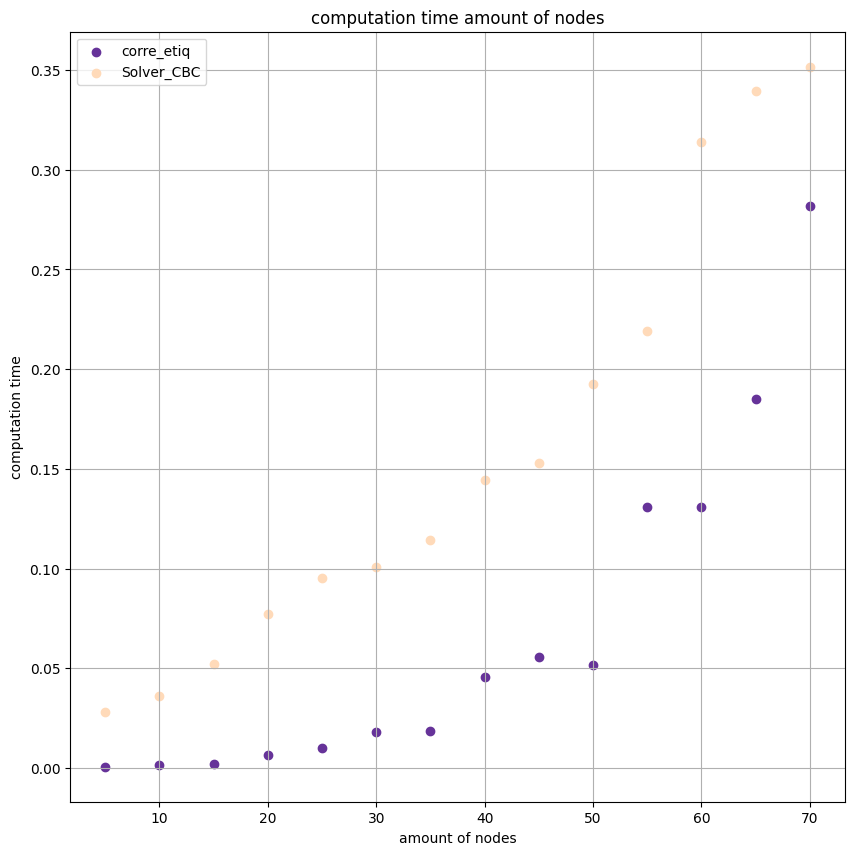

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(N_list, tmp_correc, c="rebeccapurple", label="corre_etiq")
plt.scatter(N_list, tmp_pulp, c="peachpuff", label="Solver_CBC")  # modèle pulp
plt.grid()
plt.xlabel("amount of nodes")
plt.ylabel("computation time")
plt.title("computation time amount of nodes")
plt.legend()

Ici on peut observer plusieurs comportements intéressants :

- On peut voir ici que pour de petites instances de notre problème, notre algorithme est plus rapide que le solveur CBC. Cependant quand le problème devient plus gros ($N>50)$ les temps de calcul sont relativements proches.

- De plus le temps de calcul du solveur CBC semble quasiment linéaire, tandis que celui de notre algorithme se rapproche plus d'un comportement exponnentiel, avec une explosion à partir de N=50.


## Le prétraitement

Le algorithmes que nous avons présenté ont des complexités relativement élevées. Le but du prétraitement va justement être de regarder le graphe et de voir si on ne peut pas enlever certains sommets ou certaines arrètes dont on sait qu'elles ne participeront pas à la solution.

Pour cela, nous avons besoin de l'algorithme de Bellman ford. On retrouve la structure classique de l'algorithme de Bellman Ford, cependant la particularité de ce dernier est que l'on place en paramètre de la fonction le nombre entier $r$. Ce nombre correspond à la métrique celons laquelle on veut calculer un plus court chemin. Par exemple si on veut calculer le chemin le moins couteux (métrique de cout) on mettra r=0. si on veut calculer le plus court chemin en termes de consommation d'une ressource, on mettra le numéro de cette ressource en paramètre.

La fonction de Bellman Ford, en plus du plus court chemin selon la métrique choisie, nous donnera sur ce même chemin, la longueur du chemin celons les différentes autres métriques.


### Création de plusieurs sous fonction.


L'algorithme de prétraitement est un algorithme qui est très long et très complexe. On y retrouve des grandes étapes que nous avons séparé en différentes fonctions, afin d'expliquer le rôle de chacune de ces étapes. C'est aussi un très bon moyen pour corriger des erreurs dans l'algorithme final si on a séparé le problème en sous problème.

#### Recherche des plus courts chemin.

Pour la réalisation de cet algorithme de prétraitement, il faut que l'on dispose de deux choses :

- les plus courts chemins entre s (la source) et tous les autres sommets du graphes pccs. Ceci se réalise avec l'algorithme de Bellman-Ford que nous avons expliqué précédemment.

- les plus courts chemins entre tous les sommets, et le sommet t (le puit). Ceci se réalise d'une manière un peu différente. Pour réaliser ceci nous avons décidé de créer un nouveau graphe gp qui contient les mêmes sommets que g mais dont tous les arcs sont retournés par rapport à g. Ensuite on effectue un Bellman Ford depuis t sur ce nouveau graphe.

- Ici on parle bien **des** plus courts chemins car nous calculons le plus court chemin pour chaque "métrique". Une métrique est une valuation des arcs qui nous permet d'attribuer une valeur à un chemin dans le graphe. Ici nous disposons de plusieurs métriques. Nous avons la métrique de cout qui est en fait la métrique principale, celle par rapport à laquelle on doit minimiser notre chemin. Nous avons ensuite les métriques de consommation, qui sont correspondent aux consommations des ressources sur chaque arc.


**Remarques :** 
+ Le problème sera dit évident si jamais on se retrouve dans le cas très simple où si on regarde le plus court chemin, selon la métrique de cout, entre la source et le puit et que ce chemin respecte les contraintes du problème.

+ Le problème sera dit insoluble si jamais on est dans le cas où on a un des plus courts chemins dans une des métriques de consommation de ressource, qui ne respecte pas la contrainte correspondant à cette ressource.


#### Mise à jour du majorant

Le but de l'algorithme est de supprimer des arcs et/ou des sommets du graphe, de façon à avoir un graphe plus petit pour que le problème soit plus petit. Ce que l'on appelle un majorant du problème c'est une valeur réelle qui va servir de borne supérieure à la longueur en cout de notre problème.

Le principe est le suivant : 

- Dans un premier temps nous allons regarder les plus courts chemins selon chaque métrique de consommation de ressources, permettant d'aller à t. Nous allons regarder sur ces plus courts chemins si toutes les contraintes de ressources sont respectées. Si elles le sont alors on regarde sur ce chemin correspondant la longueur selon la métrique de cout et si cette dernière est inférieure au majorant on met le majorant à jour.

- Dans la seconde partie nous allons boucler sur les arrêtes (u,v) de notre graphe. On va venir former les chemins du type s->u->v->t. On va former différents chemins en regardant les plus courts selon chaque métrique sur chaque portion s->u ou v->t. Ces différents chemins vont nous permettre ainsi de mettre à jour notre majorant.


#### Elimination des sommets

La fonction va nous permettre de supprimer certains nœuds du graphe qui ne font pas parti de notre plus court chemin. 
la philosophie est assez simple. On considère un nœud $i$, et on regarde les plus courts chemins pour faire $s->i$ puis $i->t$ 
selon toutes les ressources. Si selon la ressource 0, cette distance est strictement supérieure au majorant, 
alors on peut supprimer le sommet et si selon les autres ressources cette distance est supérieure strictement 
aux limites du problème, on peut aussi supprimer ce sommet.

#### Elimination des arcs

Cette fonction nous permet d'éliminer des arcs, et la philosophie est exactement 
la même que pour supprimer des sommets sauf que maintenant on considère un arc $(i,j)$, et on regarde $s->i$, $i->j$ et $j->t$ 
et on compare ce chemin au majorant et aux limites de ressources.

#### Algorithme de prétraitement

Nous rassemblons ensuite toutes ces fonctions, dans l'algorithme final qui nous donne ainsi notre algorithme de nettoyage de graphe.

#### Test algorithme de nettoyage.

Cet algorithme est très compliqué à venir vérifier car dans son exécution il est assez complexe et long, ainsi il est compliqué de prévoir les arcs ou les nœuds qui vont être éliminés au cours des opérations, ainsi pour tester cet algorithme nous allons créer des graphes aléatoires, faire tourner l'algorithme de correction d'étiquette qui lui a été vérifié, ensuite nous allons faire tourner l'algorithme de nettoyage et ensuite de nouveau l'algorithme de correction, pour voir si nous obtenons les mêmes résultats avec les deux méthodes.

In [13]:
N = 70  # nombre de noeuds dans le graphe.
s, t = random_choose_node(N)
b = [100, 200, 200]
g, C, A, dict_R, dict_b = make_random_graphe(N, 3, 200, b, 0.6)

corr = Correc_Etiq_bis(g, s, t, 3, b)
print("nombre de noeuds avant nettoyage : {}".format(len(g.nodes())))
print("nombre d'arrètes avant nettoyage : {}".format(len(g.edges())))
print("Resultat sans nettoyage : ", end="")
print(corr)
print("")
print("-------")
print("")

gp = nettoyage(g, s, t, b, 3)["graphe"]  # on nettoie le graphe.
corr2 = Correc_Etiq_bis(gp, s, t, 3, b)
print("nombre de noeuds après nettoyage : {}".format(len(gp.nodes())))
print("nombre d'arrètes après nettoyage : {}".format(len(gp.edges())))
print("Resultat avec nett : ", end="")
print(corr2)

nombre de noeuds avant nettoyage : 70
nombre d'arrètes avant nettoyage : 2906
Resultat sans nettoyage : {'pcc': [134, 40, 174, 99], 'trace': [27, 41, 26], 'temps': 0.05879700000000554, 'etat': 'resolu'}

-------

nombre de noeuds après nettoyage : 3
nombre d'arrètes après nettoyage : 2
Resultat avec nett : {'pcc': [134, 40, 174, 99], 'trace': [27, 41, 26], 'temps': 0.00039740000000421105, 'etat': 'resolu'}


Nous avons fait tourner cette cellule de nombreuses fois, et à chaque fois l'algorithme de nettoyage, nous permettait de réduire considérablement le graph, et ainsi le temps de calcul de l'algorithme de correction d'étiquette. Ce qui serait maintenant intéressant, c'est de comparer les temps de calcul de l'algorithme de correction d'étiquette, avec et sans nettoyage. En effet si le nettoyage est beaucoup trop long, il n'a aucun intérêt dans la résolution de notre problème. c'est ce que nous allons faire ici. Nous allons procéder de manière très similaire à la mise en avant de la complexité.

In [14]:
tmp_std = []  # temps sans nettoyage
tmp_nett = []  # temps avec nettoyage.
N_list = np.arange(20, 75, 5)


for N in N_list:
    s = 0
    t = N - 1
    buff_1 = []
    buff_2 = []

    b = [200, 200, 200]

    for i in range(10):
        g, C, A, dict_R, dict_b = make_random_graphe(
            N, 3, 200, b, 0.6
        )  # on fait un graphe aléatoire.

        ## Correction ###
        buff_1.append(Correc_Etiq_bis(g, s, t, 3, b)["temps"])

        ## Correction + Nettoyage ##
        t1 = time()
        gp = nettoyage(g, s, t, b, 3)["graphe"]
        cor = Correc_Etiq_bis(gp, s, t, 3, b)["temps"]
        t2 = time()

        buff_2.append(t2 - t1)

    m1 = np.mean(buff_1)
    m2 = np.mean(buff_2)

    tmp_std.append(m1)
    tmp_nett.append(m2)

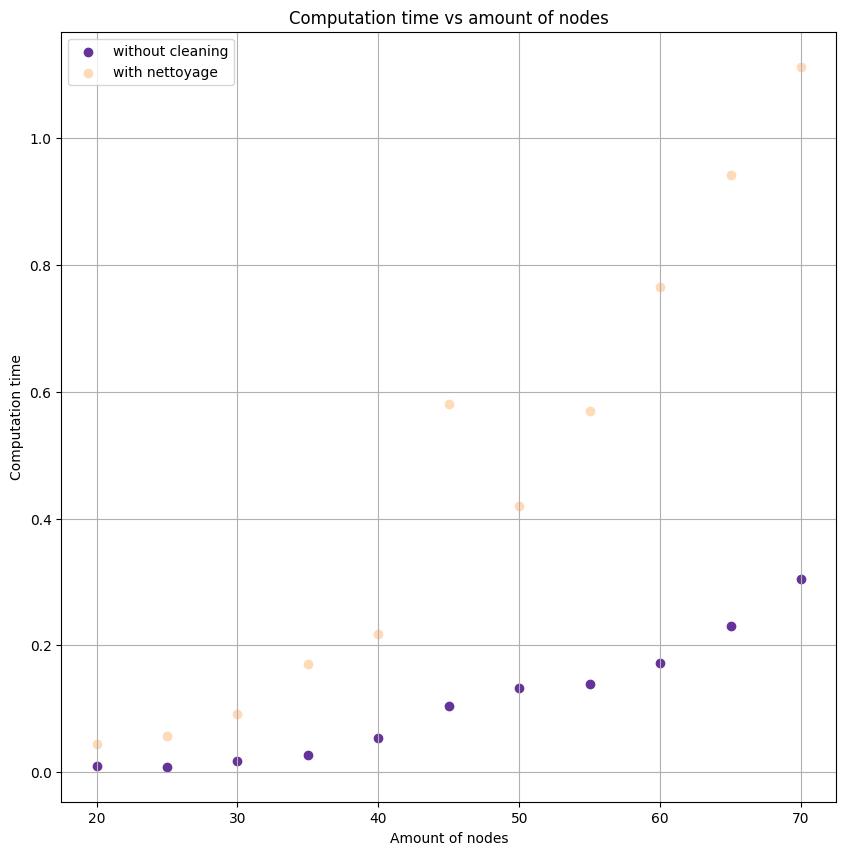

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(N_list, tmp_std, c="rebeccapurple", label="sans nettoayge")
plt.scatter(N_list, tmp_nett, c="peachpuff", label="avec nettoyage")  # modèle pulp
plt.grid()
plt.xlabel("Amount of nodes")
plt.ylabel("Computation time")
plt.title("Computation time vs amount of")
plt.legend()

On peut voir ici que justement, faire tourener l'algortihme de nettoyage ne fait que augmenter considérablement le temps de calcul et n'a donc ici pas de réel utilité.